# Séance 3 — Statsmodels & analyses statistiques de base

## 🎯 Objectifs
- Réaliser des tests statistiques simples
- Comprendre et implémenter des régressions linéaires pour features diagnostics
- Maîtriser les statistiques descriptives avancées
- Effectuer des tests d'hypothèses

---

## 📚 Introduction

**Statsmodels** est une bibliothèque Python pour l'estimation de modèles statistiques et les tests statistiques. Elle offre des outils complets pour l'analyse de régression, les tests d'hypothèses, et plus encore.

**Installation :**
```bash
pip install statsmodels scipy pandas numpy matplotlib
```

In [1]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats import diagnostic
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 📖 Pourquoi faire des tests statistiques ?

### 🎯 L'importance des tests statistiques

Les tests statistiques sont essentiels en data science et machine learning pour:

1. **Valider les hypothèses** : Vérifier si nos observations sont dues au hasard ou à des effets réels
2. **Prendre des décisions éclairées** : Baser nos choix sur des preuves statistiques plutôt que sur l'intuition
3. **Évaluer la fiabilité** : Comprendre la confiance que nous pouvons avoir dans nos résultats
4. **Comparer des groupes** : Déterminer si des différences observées sont significatives
5. **Valider les modèles** : Vérifier que les hypothèses de nos modèles (comme la régression) sont respectées

### 📊 Types de tests statistiques

| Type de test | Objectif | Quand l'utiliser | Exemple |
|-------------|----------|------------------|---------|
| **Test de normalité** | Vérifier si les données suivent une distribution normale | Avant d'appliquer des tests paramétriques | Shapiro-Wilk, Kolmogorov-Smirnov |
| **Test t (Student)** | Comparer les moyennes de deux groupes | Comparer deux échantillons indépendants | Comparer les ventes avant/après une campagne |
| **Test de Chi-2** | Tester l'indépendance entre variables catégorielles | Analyser des tableaux de contingence | Relation entre genre et préférence produit |
| **ANOVA** | Comparer les moyennes de 3+ groupes | Comparer plusieurs groupes simultanément | Comparer les performances de 5 algorithmes |
| **Test de corrélation** | Mesurer la relation entre deux variables | Évaluer la force d'une relation linéaire | Corrélation entre température et ventes |
| **Tests non-paramétriques** | Alternative quand les données ne sont pas normales | Données ordinales ou non-normales | Mann-Whitney, Kruskal-Wallis |

### 🔍 Comment interpréter les résultats ?

#### La p-value (valeur p)

La **p-value** est la probabilité d'observer les résultats obtenus (ou plus extrêmes) si l'hypothèse nulle était vraie.

| p-value | Interprétation | Décision |
|---------|---------------|----------|
| **p < 0.001** | Très forte évidence contre H₀ | ⭐⭐⭐ Hautement significatif |
| **p < 0.01** | Forte évidence contre H₀ | ⭐⭐ Très significatif |
| **p < 0.05** | Évidence modérée contre H₀ | ⭐ Significatif (seuil standard) |
| **p < 0.10** | Évidence faible contre H₀ | 🤔 Marginalement significatif |
| **p ≥ 0.05** | Pas d'évidence contre H₀ | ❌ Non significatif |

**Interprétation** :
- Si **p < 0.05** : On rejette l'hypothèse nulle (H₀) → Les différences sont statistiquement significatives
- Si **p ≥ 0.05** : On ne peut pas rejeter H₀ → Pas de preuve de différence significative

#### Les hypothèses

**Hypothèse nulle (H₀)** : "Il n'y a pas d'effet" ou "Pas de différence entre les groupes"
**Hypothèse alternative (H₁)** : "Il y a un effet" ou "Il y a une différence"

#### Risques d'erreur

| Type d'erreur | Description | Symbole | Conséquence |
|---------------|-------------|---------|-------------|
| **Erreur de Type I** | Rejeter H₀ alors qu'elle est vraie (faux positif) | α (alpha) | Croire à un effet qui n'existe pas |
| **Erreur de Type II** | Ne pas rejeter H₀ alors qu'elle est fausse (faux négatif) | β (beta) | Rater un effet qui existe |

**Le niveau de signification α** (usuellement 0.05) représente le risque qu'on accepte de commettre une erreur de Type I.

### 📐 Statistiques descriptives vs inférentielles

| Aspect | Statistiques descriptives | Statistiques inférentielles |
|--------|--------------------------|---------------------------|
| **Objectif** | Résumer et décrire les données | Tirer des conclusions sur la population |
| **Méthodes** | Moyenne, médiane, écart-type, graphiques | Tests d'hypothèses, intervalles de confiance |
| **Question** | "Que disent mes données ?" | "Puis-je généraliser à la population ?" |
| **Exemple** | "La moyenne d'âge est 35 ans" | "L'âge moyen de la population est entre 33 et 37 ans (95% confiance)" |

### 💡 Règles d'or

1. **Toujours visualiser** les données avant de tester
2. **Vérifier les hypothèses** du test (normalité, homoscédasticité, etc.)
3. **Ne pas confondre** significativité statistique et importance pratique
4. **Considérer la taille d'effet** en plus de la p-value
5. **Ajuster pour les tests multiples** si vous faites plusieurs comparaisons
6. **Interpréter avec le contexte** : une différence significative n'est pas toujours importante en pratique

---

## 📊 1. Préparation des données

Nous allons créer un jeu de données simulé représentant des documents avec différentes caractéristiques.

In [2]:
# Création d'un dataset de documents
np.random.seed(42)
n_docs = 500

# Génération des features
longueur = np.random.normal(1000, 300, n_docs).clip(100, 3000)
mots_rares = np.random.poisson(20, n_docs)
phrases_longues = np.random.normal(15, 5, n_docs).clip(0, 40)
niveau_technique = np.random.choice([1, 2, 3, 4, 5], n_docs)

# Variable cible : difficulté (fonction de plusieurs features + bruit)
difficulte = (
    0.002 * longueur +
    0.15 * mots_rares +
    0.3 * phrases_longues +
    2 * niveau_technique +
    np.random.normal(0, 3, n_docs)
).clip(1, 100)

# Création du DataFrame
df = pd.DataFrame({
    'longueur': longueur,
    'mots_rares': mots_rares,
    'phrases_longues': phrases_longues,
    'niveau_technique': niveau_technique,
    'difficulte': difficulte
})

print("Dataset créé avec succès!")
print(f"Dimensions: {df.shape}")
print("\nPremières lignes:")
df.head()

Dataset créé avec succès!
Dimensions: (500, 5)

Premières lignes:


,longueur,mots_rares,phrases_longues,niveau_technique,difficulte
0,1149.014246,22,14.149077,4,19.794102
1,958.520710,21,12.733860,5,14.377958
2,1194.306561,13,18.481937,5,23.039037
3,1456.908957,16,19.776526,2,12.252594
4,929.753988,15,15.442034,5,17.590204


## 📈 2. Statistiques descriptives avancées

In [3]:
# Statistiques descriptives complètes
print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)
print(df.describe())

print("\n" + "=" * 60)
print("ASYMÉTRIE (SKEWNESS) ET APLATISSEMENT (KURTOSIS)")
print("=" * 60)
for col in df.columns:
    skew = stats.skew(df[col])
    kurt = stats.kurtosis(df[col])
    print(f"{col:20s} | Skewness: {skew:7.3f} | Kurtosis: {kurt:7.3f}")

STATISTIQUES DESCRIPTIVES
          longueur  mots_rares  phrases_longues  niveau_technique  difficulte
count   500.000000  500.000000       500.000000        500.000000  500.000000
mean   1002.196159   19.932000        15.152683          3.042000   15.736483
std     293.913267    4.646995         4.918828          1.433997    4.418718
min     100.000000    7.000000         0.298057          1.000000    4.776619
25%     789.907779   16.750000        11.927300          2.000000   12.777515
50%    1003.839144   20.000000        14.904679          3.000000   15.792100
75%    1191.034976   23.000000        18.482646          4.000000   18.703329
max    2155.819447   34.000000        30.965538          5.000000   28.376533

ASYMÉTRIE (SKEWNESS) ET APLATISSEMENT (KURTOSIS)
longueur             | Skewness:   0.194 | Kurtosis:   0.212
mots_rares           | Skewness:   0.254 | Kurtosis:   0.063
phrases_longues      | Skewness:  -0.063 | Kurtosis:   0.251
niveau_technique     | Skewness:  -0.04

## 🔗 3. Analyse de corrélation

Matrice de corrélation:
                  longueur  mots_rares  phrases_longues  niveau_technique  \
longueur          1.000000   -0.017491        -0.023245          0.006990   
mots_rares       -0.017491    1.000000         0.021651         -0.023930   
phrases_longues  -0.023245    0.021651         1.000000          0.047325   
niveau_technique  0.006990   -0.023930         0.047325          1.000000   
difficulte        0.152229    0.140742         0.304911          0.676857   

                  difficulte  
longueur            0.152229  
mots_rares          0.140742  
phrases_longues     0.304911  
niveau_technique    0.676857  
difficulte          1.000000  


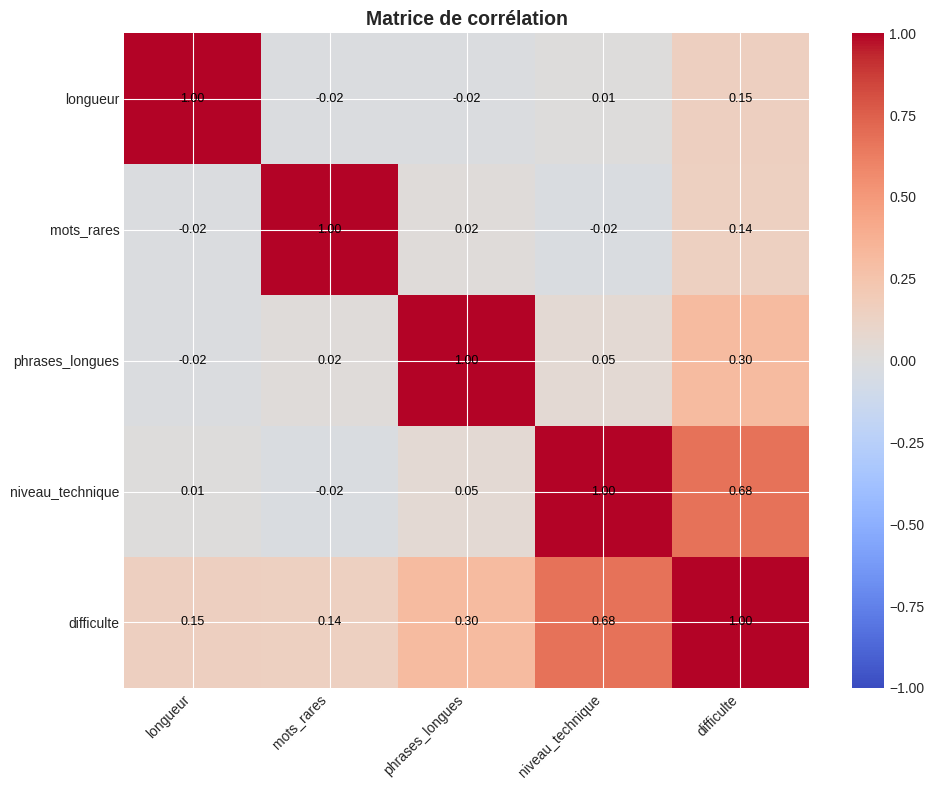

In [4]:
# Matrice de corrélation
corr_matrix = df.corr()
print("Matrice de corrélation:")
print(corr_matrix)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns)

# Ajouter les valeurs dans les cellules
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax)
plt.title('Matrice de corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 🧪 4. Tests d'hypothèses

### Test de normalité (Shapiro-Wilk)

In [5]:
# Test de normalité pour chaque variable
print("=" * 60)
print("TESTS DE NORMALITÉ (Shapiro-Wilk)")
print("=" * 60)
for col in df.columns:
    stat, p_value = stats.shapiro(df[col])
    is_normal = "OUI" if p_value > 0.05 else "NON"
    print(f"{col:20s} | p-value: {p_value:.4f} | Normal: {is_normal}")

TESTS DE NORMALITÉ (Shapiro-Wilk)
longueur             | p-value: 0.3853 | Normal: OUI
mots_rares           | p-value: 0.0010 | Normal: NON
phrases_longues      | p-value: 0.5613 | Normal: OUI
niveau_technique     | p-value: 0.0000 | Normal: NON
difficulte           | p-value: 0.6439 | Normal: OUI


### Test t de Student (comparaison de moyennes)

In [6]:
# Comparer la difficulté entre documents de niveau technique bas (1-2) et haut (4-5)
niveau_bas = df[df['niveau_technique'].isin([1, 2])]['difficulte']
niveau_haut = df[df['niveau_technique'].isin([4, 5])]['difficulte']

t_stat, p_value = stats.ttest_ind(niveau_bas, niveau_haut)

print("=" * 60)
print("TEST T DE STUDENT")
print("=" * 60)
print(f"Moyenne difficulté (niveau bas):  {niveau_bas.mean():.2f}")
print(f"Moyenne difficulté (niveau haut): {niveau_haut.mean():.2f}")
print(f"\nStatistique t: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"\nConclusion: La différence est {'significative' if p_value < 0.05 else 'non significative'} (α=0.05)")

TEST T DE STUDENT
Moyenne difficulté (niveau bas):  12.59
Moyenne difficulté (niveau haut): 18.80

Statistique t: -18.1474
p-value: 0.0000

Conclusion: La différence est significative (α=0.05)


## 📉 5. Régression linéaire simple (OLS)

### Modèle univarié : longueur → difficulté

In [7]:
# Préparation des données
X = df['longueur']
y = df['difficulte']

# Ajout de la constante (intercept)
X_with_const = sm.add_constant(X)

# Estimation du modèle
model_simple = sm.OLS(y, X_with_const)
results_simple = model_simple.fit()

# Affichage du résumé
print(results_simple.summary())

                            OLS Regression Results                            
Dep. Variable:             difficulte   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     11.81
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           0.000637
Time:                        19:06:32   Log-Likelihood:                -1446.0
No. Observations:                 500   AIC:                             2896.
Df Residuals:                     498   BIC:                             2904.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4428      0.695     19.332      0.0

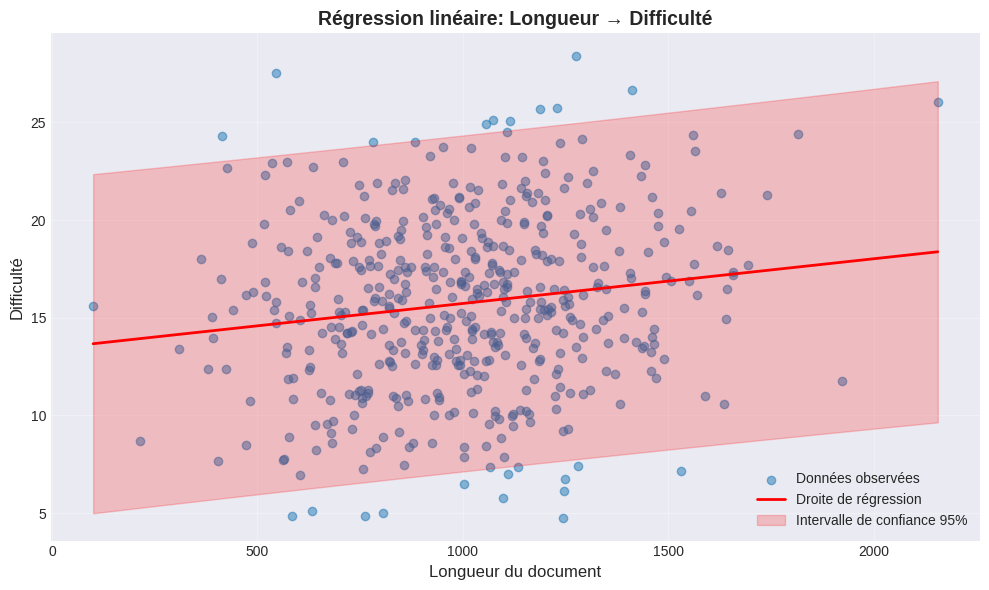


Équation: Difficulté = 13.44 + 0.0023 × Longueur
R² = 0.0232


In [8]:
# Visualisation du modèle
fig, ax = plt.subplots(figsize=(10, 6))

# Points observés
ax.scatter(X, y, alpha=0.5, label='Données observées')

# Droite de régression
x_pred = np.linspace(X.min(), X.max(), 100)
X_pred_const = sm.add_constant(x_pred)
y_pred = results_simple.predict(X_pred_const)
ax.plot(x_pred, y_pred, 'r-', linewidth=2, label='Droite de régression')

# Intervalle de confiance
predictions = results_simple.get_prediction(X_pred_const)
pred_summary = predictions.summary_frame(alpha=0.05)
ax.fill_between(x_pred, pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'],
                alpha=0.2, color='red', label='Intervalle de confiance 95%')

ax.set_xlabel('Longueur du document', fontsize=12)
ax.set_ylabel('Difficulté', fontsize=12)
ax.set_title('Régression linéaire: Longueur → Difficulté', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nÉquation: Difficulté = {results_simple.params[0]:.2f} + {results_simple.params[1]:.4f} × Longueur")
print(f"R² = {results_simple.rsquared:.4f}")

## 📊 6. Régression linéaire multiple

### Modèle multivarié : toutes les features → difficulté

In [9]:
# Préparation des données
X_multi = df[['longueur', 'mots_rares', 'phrases_longues', 'niveau_technique']]
y_multi = df['difficulte']

# Ajout de la constante
X_multi_const = sm.add_constant(X_multi)

# Estimation du modèle
model_multi = sm.OLS(y_multi, X_multi_const)
results_multi = model_multi.fit()

# Affichage du résumé
print(results_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             difficulte   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     170.9
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           8.16e-92
Time:                        19:06:35   Log-Likelihood:                -1235.0
No. Observations:                 500   AIC:                             2480.
Df Residuals:                     495   BIC:                             2501.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4946      0.865  

## 🔍 7. Diagnostics de régression

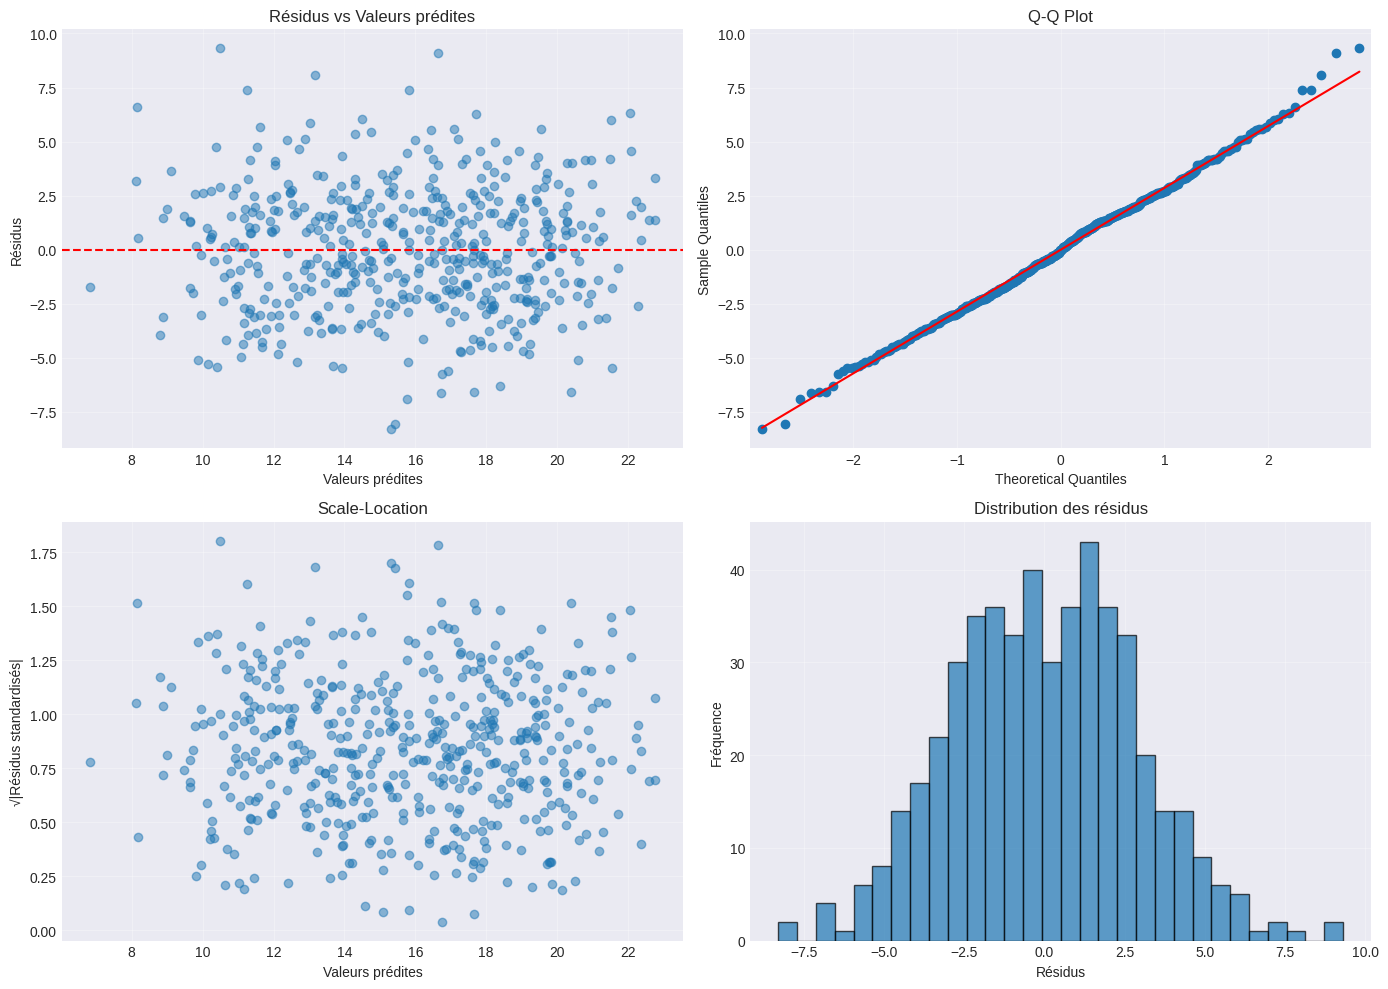

In [10]:
# Graphiques de diagnostic
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Résidus vs valeurs prédites
residuals = results_multi.resid
fitted = results_multi.fittedvalues
axes[0, 0].scatter(fitted, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Valeurs prédites')
axes[0, 0].set_ylabel('Résidus')
axes[0, 0].set_title('Résidus vs Valeurs prédites')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot (normalité des résidus)
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location (homoscédasticité)
standardized_resid = np.sqrt(np.abs((residuals - residuals.mean()) / residuals.std()))
axes[1, 0].scatter(fitted, standardized_resid, alpha=0.5)
axes[1, 0].set_xlabel('Valeurs prédites')
axes[1, 0].set_ylabel('√|Résidus standardisés|')
axes[1, 0].set_title('Scale-Location')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histogramme des résidus
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Résidus')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution des résidus')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📋 8. Comparaison des modèles

In [11]:
# Tableau comparatif
comparison = pd.DataFrame({
    'Modèle': ['Simple (longueur)', 'Multiple (toutes features)'],
    'R²': [results_simple.rsquared, results_multi.rsquared],
    'R² ajusté': [results_simple.rsquared_adj, results_multi.rsquared_adj],
    'AIC': [results_simple.aic, results_multi.aic],
    'BIC': [results_simple.bic, results_multi.bic],
    'RMSE': [
        np.sqrt(np.mean(results_simple.resid**2)),
        np.sqrt(np.mean(results_multi.resid**2))
    ]
})

print("=" * 80)
print("COMPARAISON DES MODÈLES")
print("=" * 80)
print(comparison.to_string(index=False))
print("\nNote: Plus le R² est élevé, mieux c'est. Plus l'AIC/BIC est faible, mieux c'est.")

COMPARAISON DES MODÈLES
                    Modèle       R²  R² ajusté         AIC         BIC     RMSE
         Simple (longueur) 0.023174   0.021212 2896.063927 2904.493143 4.362849
Multiple (toutes features) 0.580011   0.576617 2480.023856 2501.096897 2.860754

Note: Plus le R² est élevé, mieux c'est. Plus l'AIC/BIC est faible, mieux c'est.


## 🎯 EXERCICE : Votre modèle OLS

**Objectif**: Créer un modèle OLS simplifié pour prédire une métrique de votre choix.

**Instructions**:
1. Choisissez une variable cible (par exemple: difficulté, longueur, etc.)
2. Sélectionnez 2-3 variables explicatives
3. Construisez le modèle OLS
4. Analysez les résultats (coefficients, p-values, R²)
5. Créez les graphiques de diagnostic
6. Interprétez les résultats

**Questions à répondre**:
- Quelles variables sont significatives ?
- Quel est le pouvoir explicatif du modèle (R²) ?
- Les hypothèses de la régression sont-elles respectées ?
- Comment améliorer le modèle ?

In [ ]:
# VOTRE CODE ICI
# Exemple de structure:

# 1. Sélection des variables
# X_ex = df[['variable1', 'variable2']]
# y_ex = df['cible']

# 2. Ajout de la constante
# X_ex_const = sm.add_constant(X_ex)

# 3. Estimation du modèle
# model_ex = sm.OLS(y_ex, X_ex_const)
# results_ex = model_ex.fit()

# 4. Affichage des résultats
# print(results_ex.summary())

# 5. Visualisations et diagnostics
# ...

## 📝 Conclusion

Dans cette séance, nous avons appris à :
- Calculer des statistiques descriptives avancées
- Effectuer des tests d'hypothèses (normalité, test t)
- Construire des modèles de régression linéaire (simple et multiple)
- Diagnostiquer et évaluer les modèles
- Interpréter les résultats statistiques

**Points clés à retenir** :
1. Les tests statistiques nécessitent des hypothèses (ex: normalité)
2. Le R² mesure la qualité de l'ajustement mais ne garantit pas la causalité
3. Les diagnostics de régression sont essentiels pour valider les modèles
4. Un modèle simple peut être préférable à un modèle complexe (principe de parcimonie)

**Ressources supplémentaires** :
- Documentation Statsmodels: https://www.statsmodels.org/
- Scipy Stats: https://docs.scipy.org/doc/scipy/reference/stats.html